<a href="https://colab.research.google.com/github/RPAlbuquerque/PhD-Dissertation---Paper-2/blob/main/Hypothesis_Test_Paper_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##🧪 BLOCK 0 — Setup and Paths

In [ ]:
# 📌 Title: Setup & Imports for Hypothesis Testing (H1 – Mobility → Sales)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For spatial models
import libpysal
import esda
import statsmodels.api as sm
import statsmodels.formula.api as smf

# For warnings and aesthetics
import warnings
warnings.filterwarnings("ignore")

# Configure plotting style
plt.style.use("seaborn-whitegrid")
sns.set_palette("Set2")

# Paths to processed datasets
mobility_path = "/n/netscratch/cga/Lab/rpalbuquerque/Mobility/aggregated_aug2024/mobility_by_sector.csv.gz"
sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_geo.csv.gz"
geometry_path = "/n/netscratch/cga/Lab/SETORES_CENSITARIOS/BR_setores_2022.shp"

print("✅ Environment ready.")

✅ Environment ready.


In [ ]:
##🔢 Block 1 – Load All Datasets & Prepare Spatial Structure (for H1)

In [ ]:
# 📌 Title: Load Sales, Mobility, and Census Geometry Data
import pandas as pd
from shapely.geometry import Point
import pyogrio
import os

# Paths
sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_geo.csv.gz"
mobility_path = "/n/netscratch/cga/Lab/rpalbuquerque/Mobility/aggregated_aug2024/mobility_by_sector.csv.gz"
shapefile_path = "/n/netscratch/cga/Lab/rpalbuquerque/GEWI 2.0/Census_Track_BR/BR_setores_CD2022.shp"

# 🔄 Load Sales Data
print("🔄 Loading sales data...")
sales_df = pd.read_csv(sales_path)
print(f"✅ Sales data loaded: {sales_df.shape}")

# 🔄 Load Mobility Data
print("🔄 Loading mobility data...")
mobility_df = pd.read_csv(mobility_path)
print(f"✅ Mobility data loaded: {mobility_df.shape}")

# 🔄 Load Census Sector Shapefile (set CRS explicitly)
print("🔄 Loading census sectors shapefile...")
setores_df = pyogrio.read_dataframe(shapefile_path, columns=["CD_GEOCODI", "geometry"])
setores_df.crs = "EPSG:4674"  # Explicitly set SIRGAS 2000 CRS
setores_df = setores_df.to_crs("EPSG:4326")  # Reproject to WGS84
print(f"✅ Census sectors loaded: {setores_df.shape}")

🔄 Loading sales data...
✅ Sales data loaded: (142724, 24)
🔄 Loading mobility data...
✅ Mobility data loaded: (260183, 9)
🔄 Loading census sectors shapefile...
✅ Census sectors loaded: (468099, 1)


In [ ]:
##🚀 Block 2 — Spatial Join (Sales + Mobility via Census Sector)

In [ ]:
# 🔧 Block 2 — Assign Census Sector to Sales Points (High Performance, Parallel)
# 📌 Title: Spatial Join — Assign Census Sector to Sales Points via STRtree + Joblib

import pandas as pd
import pyogrio
from shapely.geometry import Point
from shapely.strtree import STRtree
from shapely.ops import transform
from functools import partial
from joblib import Parallel, delayed
from tqdm import tqdm
import pyproj
import time
import os

# Paths
sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_geo.csv.gz"
gpkg_path = "/n/netscratch/cga/Lab/rpalbuquerque/e-WOM/BR_setores_CD2022.gpkg"
gpkg_layer = "BR_setores_CD2022"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_sector.csv.gz"

# Step 1: Load sales data
print("🔄 Loading sales data...")
sales_df = pd.read_csv(sales_path)
print(f"✅ Sales: {sales_df.shape}")

# Step 2: Create geometry column
print("🧱 Creating geometry column...")
sales_df["geometry"] = sales_df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)

# Step 3: Load census sectors
print("🗺️ Loading census sectors...")
start = time.time()
setores_df = pyogrio.read_dataframe(gpkg_path, layer=gpkg_layer, columns=["CD_SETOR", "geometry"])
print(f"✅ Loaded {setores_df.shape[0]:,} polygons in {time.time() - start:.2f}s")

# Step 4: CRS reproject (if needed)
if setores_df.crs is None or setores_df.crs.to_epsg() != 4326:
    print("🔁 Reprojecting to EPSG:4326...")
    project = partial(
        pyproj.transform,
        pyproj.CRS("EPSG:4674"),
        pyproj.CRS("EPSG:4326")
    )
    setores_df["geometry"] = setores_df["geometry"].apply(lambda g: transform(project, g))
    print("✅ Reprojection complete.")

# Step 5: Spatial index setup
print("⚙️ Building spatial index...")
geoms = setores_df["geometry"].tolist()
codes = setores_df["CD_SETOR"].tolist()
index = STRtree(geoms)

# Step 6: Define lookup function
def match_sector(pt):
    matches = index.query(pt)
    for i in matches:
        if geoms[i].contains(pt):
            return codes[i]
    return None

# Step 7: Parallel spatial join
print("📌 Performing spatial join in parallel...")
start = time.time()
points = sales_df["geometry"].tolist()

with Parallel(n_jobs=-1, prefer="threads") as parallel:
    setores = parallel(delayed(match_sector)(pt) for pt in tqdm(points, desc="🔎 Matching sectors"))

sales_df["CD_SETOR"] = setores
print(f"✅ Spatial join done in {time.time() - start:.2f}s")
print(f"🧮 Points matched: {sales_df['CD_SETOR'].notna().sum():,} of {len(sales_df):,}")

# Step 8: Save result
sales_df.drop(columns=["geometry"], inplace=True)
sales_df.to_csv(output_path, index=False, compression="gzip")
print(f"💾 Saved final file with census sectors: {output_path}")

🔄 Loading sales data...
✅ Sales: (142724, 24)
🧱 Creating geometry column...
🗺️ Loading census sectors...
✅ Loaded 472,780 polygons in 17.81s
🔁 Reprojecting to EPSG:4326...
✅ Reprojection complete.
⚙️ Building spatial index...
📌 Performing spatial join in parallel...


🔎 Matching sectors: 100%|██████████| 142724/142724 [00:11<00:00, 12276.20it/s]


✅ Spatial join done in 11.65s
🧮 Points matched: 142,412 of 142,724
💾 Saved final file with census sectors: /n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_sector.csv.gz


In [ ]:
##🔧 Block 3 — Aggregate Sales and Merge with Mobility

In [ ]:
# 📋 Inspect Columns of Mobility Dataset

import pandas as pd

# Caminho para o arquivo de mobilidade
mobility_path = "/n/netscratch/cga/Lab/rpalbuquerque/Mobility/aggregated_aug2024/mobility_by_sector.csv.gz"

# Lê apenas o cabeçalho
df_mob = pd.read_csv(mobility_path, nrows=5)

print("🧾 Columns in mobility dataset:")
for col in df_mob.columns:
    print(f"• {col}")
# 👀 Preview formatted (Jupyter-friendly)
from IPython.display import display

mobility_df = pd.read_csv("/n/netscratch/cga/Lab/rpalbuquerque/Mobility/aggregated_aug2024/mobility_by_sector.csv.gz")
display(mobility_df.head())


🧾 Columns in mobility dataset:
• code_censo
• total_unique_visitors
• total_visits
• raw_unique_visitors
• raw_total_visits
• total_repeat_visitors
• total_new_visitors
• avg_dwell_time_mins
• state


,code_censo,total_unique_visitors,total_visits,raw_unique_visitors,raw_total_visits,total_repeat_visitors,total_new_visitors,avg_dwell_time_mins,state
0,130002905000001,14259.602588,153317.287334,64.081064,405.055616,13557.072860,14259.602588,91.821414,AM
1,130002905000003,21741.616478,205872.422790,75.540729,433.603786,19965.812157,21741.616478,89.826978,AM
2,130002905000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,AM
3,130002905000008,2696.924861,20697.250077,5.568521,20.881953,2696.924861,2696.924861,80.992262,AM
4,130002905000010,1025.096756,6830.425454,6.097506,23.712523,923.979233,1025.096756,99.054938,AM


In [ ]:
import pandas as pd
import os
import time

# Paths
sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_sector.csv.gz"
mobility_path = "/n/netscratch/cga/Lab/rpalbuquerque/Mobility/aggregated_aug2024/mobility_by_sector.csv.gz"
output_dir = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test"
output_path = os.path.join(output_dir, "sales_mobility_merged.csv.gz")

# Step 1: Load datasets
print("🔄 Loading sales with census sector...")
sales_df = pd.read_csv(sales_path, usecols=["CD_SETOR", "total_sales"])
print(f"✅ Sales data: {sales_df.shape}")

print("🔄 Loading mobility data...")
mobility_df = pd.read_csv(mobility_path)
print(f"✅ Mobility data: {mobility_df.shape}")

# Step 2: Aggregate sales by CD_SETOR
print("📊 Aggregating sales by CD_SETOR...")
start = time.time()
sales_agg = sales_df.groupby("CD_SETOR", as_index=False)["total_sales"].sum()
print(f"✅ Aggregated: {sales_agg.shape} rows in {time.time()-start:.2f}s")

# Step 3: Merge with mobility data
print("🔗 Merging with mobility data...")
start = time.time()
merged_df = pd.merge(
    sales_agg,
    mobility_df,
    left_on="CD_SETOR",
    right_on="code_censo",
    how="inner"
)
print(f"✅ Merged dataset: {merged_df.shape} in {time.time()-start:.2f}s")

# Step 4: Save merged result
print("💾 Saving final merged file...")
os.makedirs(output_dir, exist_ok=True)
merged_df.to_csv(output_path, index=False, compression="gzip")
print(f"🎉 Done! Final file saved to:\n{output_path}")

🔄 Loading sales with census sector...
✅ Sales data: (142724, 2)
🔄 Loading mobility data...
✅ Mobility data: (260183, 9)
📊 Aggregating sales by CD_SETOR...
✅ Aggregated: (7839, 2) rows in 0.00s
🔗 Merging with mobility data...
✅ Merged dataset: (4139, 11) in 0.02s
💾 Saving final merged file...
🎉 Done! Final file saved to:
/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz


In [ ]:
##🔬 Block 4 — Hypothesis H1: Mobility → Sales

🔄 Loading merged dataset...
✅ Data loaded: (4139, 11)
🧮 Preparing variables for regression...
📈 Fitting linear regression model (OLS)...
✅ Model fitted in 0.20s

📊 Regression Results (H1):

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     35.26
Date:                Mon, 12 May 2025   Prob (F-statistic):           3.13e-09
Time:                        20:27:09   Log-Likelihood:                -52551.
No. Observations:                4139   AIC:                         1.051e+05
Df Residuals:                    4137   BIC:                         1.051e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    

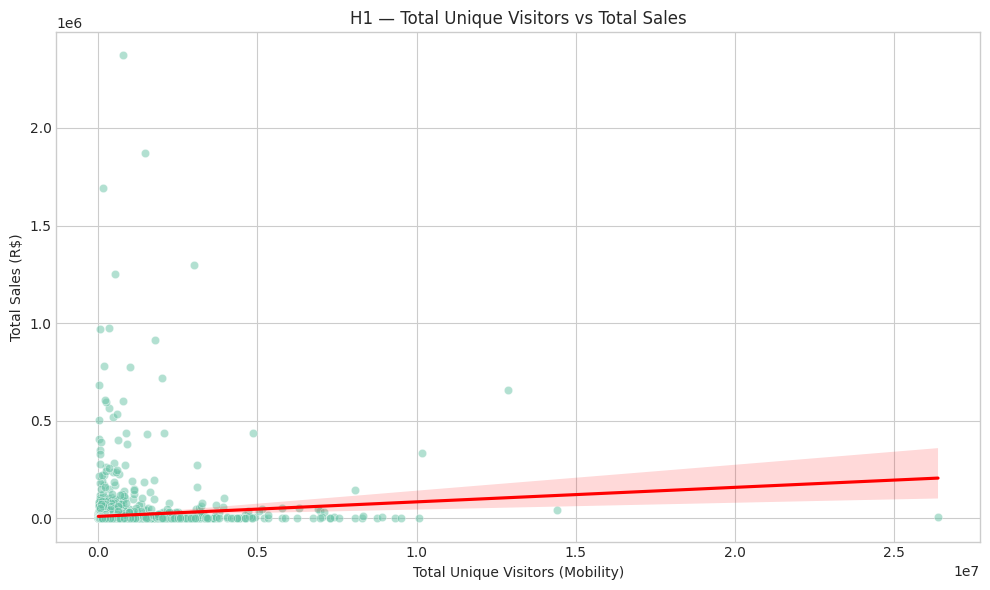

In [ ]:
# 🔬 Block 4 — Hypothesis H1: Mobility → Sales
# 📌 Title: Linear Regression — Mobility Impact on Sales (OLS, Real-time Output)

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Step 1 — Load merged dataset
input_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz"
print("🔄 Loading merged dataset...")
df = pd.read_csv(input_path)
print(f"✅ Data loaded: {df.shape}")

# Step 2 — Prepare variables
print("🧮 Preparing variables for regression...")
X = df["total_unique_visitors"]
y = df["total_sales"]

# Step 3 — Add constant and fit model
X = sm.add_constant(X)
print("📈 Fitting linear regression model (OLS)...")
start = time.time()
model = sm.OLS(y, X).fit()
print(f"✅ Model fitted in {time.time()-start:.2f}s")

# Step 4 — Summary
print("\n📊 Regression Results (H1):\n")
print(model.summary())

# Step 5 — Plot: Mobility vs Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x="total_unique_visitors", y="total_sales", data=df, alpha=0.5)
sns.regplot(x="total_unique_visitors", y="total_sales", data=df, scatter=False, color="red")
plt.title("H1 — Total Unique Visitors vs Total Sales")
plt.xlabel("Total Unique Visitors (Mobility)")
plt.ylabel("Total Sales (R$)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
##🔧 Block 5A — Log Transformation + Robust OLS (H1 Refined)

In [ ]:
# 📌 Title: Log-Transformed OLS Regression — Mobility → Log(Sales)

import pandas as pd
import statsmodels.api as sm
import numpy as np
import time

# Step 1: Load merged dataset
input_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz"
print("🔄 Loading merged dataset...")
df = pd.read_csv(input_path)
print(f"✅ Data loaded: {df.shape}")

# Step 2: Prepare variables
print("🔧 Preparing variables (log transform)...")
df["log_sales"] = np.log1p(df["total_sales"])
X = sm.add_constant(df["total_unique_visitors"])
y = df["log_sales"]

# Step 3: Fit OLS model
print("📈 Fitting log-level regression model...")
start = time.time()
model = sm.OLS(y, X).fit()
elapsed = time.time() - start
print(f"✅ Model fitted in {elapsed:.2f}s")

# Step 4: Display results
print("\n📊 Regression Results (H1 - Refined with log_sales):\n")
print(model.summary())

🔄 Loading merged dataset...
✅ Data loaded: (4139, 11)
🔧 Preparing variables (log transform)...
📈 Fitting log-level regression model...
✅ Model fitted in 0.00s

📊 Regression Results (H1 - Refined with log_sales):

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     27.80
Date:                Mon, 12 May 2025   Prob (F-statistic):           1.41e-07
Time:                        20:29:58   Log-Likelihood:                -9130.1
No. Observations:                4139   AIC:                         1.826e+04
Df Residuals:                    4137   BIC:                         1.828e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                       

In [ ]:
##Block 5B – Spatial Lag Model

In [ ]:
import sys
!{sys.executable} -m pip install libpysal spreg

In [ ]:
##🔧 Block 6 — Spatial Lag Model (H1)

In [ ]:
# 📌 Title: Spatial Lag Model — H1: Mobility → Sales (with spatial dependence)

import pandas as pd
from libpysal.weights import KNN
from spreg import ML_Lag
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Load dataset
path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz"
print("🔄 Loading merged data...")
df = pd.read_csv(path)
print(f"✅ Data loaded: {df.shape}")

# Step 2: Prepare variables
print("🧮 Preparing variables...")
y = df["total_sales"].values.reshape(-1, 1)
X = df[["total_unique_visitors"]].values

# Step 3: Fix CD_SETOR and generate synthetic coordinates
df["CD_SETOR"] = df["CD_SETOR"].astype(str).str.replace(".0", "", regex=False).str.zfill(15)

scaler = MinMaxScaler()
df["x_coord"] = scaler.fit_transform(df["CD_SETOR"].str[-6:].astype(int).values.reshape(-1, 1))
df["y_coord"] = scaler.fit_transform(df["CD_SETOR"].str[:6].astype(int).values.reshape(-1, 1))

coords = df[["x_coord", "y_coord"]].values

# Step 4: Spatial Weights Matrix (KNN)
print("🌐 Building spatial weights matrix...")
w = KNN.from_array(coords, k=8)
w.transform = "r"
print("✅ Spatial weights ready.")

# Step 5: Fit Spatial Lag Model
print("📈 Fitting Spatial Lag Model...")
model = ML_Lag(y, X, w=w, name_y="total_sales", name_x=["total_unique_visitors"], name_w="KNN-8")
print("✅ Model fitted.")

# Step 6: Display Results
print("\n📊 Spatial Lag Model Results (H1):\n")
print(model.summary)

🔄 Loading merged data...
✅ Data loaded: (4139, 11)
🧮 Preparing variables...
🌐 Building spatial weights matrix...
✅ Spatial weights ready.
📈 Fitting Spatial Lag Model...
✅ Model fitted.

📊 Spatial Lag Model Results (H1):

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       KNN-8
Dependent Variable  : total_sales                Number of Observations:        4139
Mean dependent var  :  13782.3563                Number of Variables   :           3
S.D. dependent var  :  79379.6376                Degrees of Freedom    :        4136
Pseudo R-squared    :      0.0092
Spatial Pseudo R-squared:  0.0084
Log likelihood      : -52549.9213
Sigma-square ML     :6241478217.8099                Akaike info criterion :  105105.843
S.E of regression   :  79003.0266                Schwarz criterion     :  105124.827

---------

In [ ]:
## 🔧 Block 6 — Spatial Lag Model with Log-Transformed Sales

In [ ]:
# 🔧 Block 6 — Spatial Lag with Log Sales (Robust CD_SETOR Handling)
# 📌 Title: Spatial Lag Regression (log_sales ~ mobility) with synthetic coords

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from libpysal.weights import KNN
from spreg import ML_Lag
import time

# Step 1: Load merged dataset
print("🔄 Loading merged data...")
df = pd.read_csv("/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz")
print(f"✅ Data loaded: {df.shape}")

# Step 2: Prepare variables
print("🧮 Preparing variables...")
df["log_sales"] = np.log1p(df["total_sales"])
df["CD_SETOR"] = df["CD_SETOR"].astype(str).str.replace(".0", "", regex=False).str.zfill(15)

# Step 3: Create synthetic spatial coordinates
scaler = MinMaxScaler()
df["x_coord"] = scaler.fit_transform(df["CD_SETOR"].str[-6:].astype(int).values.reshape(-1, 1))
df["y_coord"] = scaler.fit_transform(df["CD_SETOR"].str[:6].astype(int).values.reshape(-1, 1))

# Step 4: Create spatial weights matrix (KNN)
print("🌐 Building spatial weights matrix...")
coords = df[["x_coord", "y_coord"]].values
w = KNN.from_array(coords, k=8)
w.transform = 'r'
print("✅ Spatial weights ready.")

# Step 5: Fit spatial lag model (log_sales ~ total_unique_visitors)
print("📈 Fitting Spatial Lag Model...")
y = df["log_sales"].values.reshape(-1, 1)
X = df[["total_unique_visitors"]].values
start = time.time()
model = ML_Lag(y, X, w=w, name_y="log_sales", name_x=["total_unique_visitors"])
print(f"✅ Model fitted in {time.time() - start:.2f}s")

# Step 6: Show results
print("\n📊 Spatial Lag Model Results (Log Sales):\n")
print(model.summary)

🔄 Loading merged data...
✅ Data loaded: (4139, 11)
🧮 Preparing variables...
🌐 Building spatial weights matrix...
✅ Spatial weights ready.
📈 Fitting Spatial Lag Model...
✅ Model fitted in 15.98s

📊 Spatial Lag Model Results (Log Sales):

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_sales                Number of Observations:        4139
Mean dependent var  :      7.3255                Number of Variables   :           3
S.D. dependent var  :      2.2043                Degrees of Freedom    :        4136
Pseudo R-squared    :      0.0781
Spatial Pseudo R-squared:  0.0017
Log likelihood      :  -9025.1173
Sigma-square ML     :      4.5141                Akaike info criterion :   18056.235
S.E of regression   :      2.1246                Schwarz criterion     :   18075.2

In [ ]:
##🔧 Block 6 — Spatial Error Model (log_sales)

In [ ]:
# 🔧 Block 6 — Spatial Error Model (H1)
# 📌 Title: Spatial Error Model — log_sales ~ total_unique_visitors

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from libpysal.weights import KNN
from spreg import GM_Error
import numpy as np
import time

# Step 1: Load dataset
print("🔄 Loading merged dataset...")
df = pd.read_csv("/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz")
print(f"✅ Data loaded: {df.shape}")

# Step 2: Log-transform sales
df["log_sales"] = np.log1p(df["total_sales"])

# Step 3: Generate synthetic spatial coordinates from CD_SETOR
scaler = MinMaxScaler()
df["x_coord"] = scaler.fit_transform(df["CD_SETOR"].astype(str).str[-6:].str.replace(".0", "", regex=False).astype(int).values.reshape(-1, 1))
df["y_coord"] = scaler.fit_transform(df["CD_SETOR"].astype(str).str[:6].astype(int).values.reshape(-1, 1))

# Step 4: Spatial weights matrix (KNN)
print("🌐 Building spatial weights matrix (KNN=8)...")
coords = df[["x_coord", "y_coord"]].values
w = KNN.from_array(coords, k=8)
w.transform = 'r'
print("✅ Spatial weights ready.")

# Step 5: Prepare variables
y = df["log_sales"].values.reshape(-1, 1)
X = df[["total_unique_visitors"]].values

# Step 6: Fit Spatial Error Model
print("📈 Fitting Spatial Error Model (log_sales)...")
start = time.time()
model = GM_Error(y, X, w=w, name_y="log_sales", name_x=["total_unique_visitors"])
elapsed = time.time() - start
print(f"✅ Model fitted in {elapsed:.2f}s\n")

# Step 7: Display results
print("📊 Spatial Error Model Results (H1):")
print(model.summary)

🔄 Loading merged dataset...
✅ Data loaded: (4139, 11)
🌐 Building spatial weights matrix (KNN=8)...
✅ Spatial weights ready.
📈 Fitting Spatial Error Model (log_sales)...
✅ Model fitted in 0.09s

📊 Spatial Error Model Results (H1):
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_sales                Number of Observations:        4139
Mean dependent var  :      7.3255                Number of Variables   :           2
S.D. dependent var  :      2.2043                Degrees of Freedom    :        4137
Pseudo R-squared    :      0.0067

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
        

In [ ]:
# 📂 Check available files in Hypothesis_Test folder
import os

path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/"
print("📂 Files in Hypothesis_Test:")
for file in sorted(os.listdir(path)):
    print("•", file)

📂 Files in Hypothesis_Test:
• sales_mobility_merged.csv.gz


In [ ]:
##📊 Block 7 — Test H2 & H3 with Interaction Effects (GEWI Moderation)

In [ ]:
# 🔧 Block 7 — Merge GEWI Data for Moderation Tests (H2 and H3)
# 📌 Title: Merge GEWI by Sector into Sales-Mobility Dataset

import pandas as pd
import os

# Step 1: Load merged sales + mobility dataset
print("🔄 Loading merged dataset...")
merged_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz"
df = pd.read_csv(merged_path)
print(f"✅ Data loaded: {df.shape}")

# Step 2: Load GEWI data and merge by CD_SETOR
gewi_path = "/n/netscratch/cga/Lab/rpalbuquerque/GEWI 2.0/gewis_por_setor.csv"
gewi_df = pd.read_csv(gewi_path)

# Sanitize column names
gewi_df.columns = gewi_df.columns.str.strip().str.lower()
df.columns = df.columns.str.strip().str.lower()

# Print available columns for manual verification
print("\n🧾 Columns in GEWI dataset:")
for col in gewi_df.columns:
    print(f"• {col}")

# Step 3: Merge GEWI into main dataset
print("\n🔗 Merging GEWI into dataset...")
merged_df = df.merge(gewi_df, how="left", left_on="cd_setor", right_on="cd_setor")
print(f"✅ Final merged dataset: {merged_df.shape}")

# Step 4: Save to disk for future use
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_merged.csv.gz"
merged_df.to_csv(output_path, index=False, compression="gzip")
print(f"💾 Final merged dataset with GEWI saved to:\n{output_path}")

🔄 Loading merged dataset...
✅ Data loaded: (4139, 11)

🧾 Columns in GEWI dataset:
• ano_mes
• cd_setor
• gewi_v1
• gewi_v2_pos
• gewi_v2_neg
• gewi_v3
• volume_tweets

🔗 Merging GEWI into dataset...
✅ Final merged dataset: (4149, 17)
💾 Final merged dataset with GEWI saved to:
/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_merged.csv.gz


In [ ]:
##🔧 Block 8 — Hypotheses H2 & H3: Interaction Effects with GEWI

In [ ]:
# 📌 Title: Moderation Analysis — Mobility × GEWI (H2 and H3)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time

# Paths
input_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_merged.csv.gz"

# Step 1: Load merged data
print("🔄 Loading merged dataset...")
df = pd.read_csv(input_path)
print(f"✅ Data loaded: {df.shape}")

# Step 2: Prepare variables
print("🧮 Preparing variables for moderation...")
df = df.copy()
df["log_sales"] = np.log1p(df["total_sales"])  # Log transform
df["gewi_pos"] = df["gewi_v2_pos"]
df["gewi_neg"] = df["gewi_v2_neg"]

# Step 3: Interaction terms
df["mob_x_pos"] = df["total_unique_visitors"] * df["gewi_pos"]
df["mob_x_neg"] = df["total_unique_visitors"] * df["gewi_neg"]

# Step 4: Fit interaction model (mobility × GEWI)
print("📈 Fitting interaction model (GEWI pos & neg)...")
start = time.time()
model = smf.ols(
    formula="log_sales ~ total_unique_visitors + gewi_pos + gewi_neg + mob_x_pos + mob_x_neg",
    data=df
).fit()
print(f"✅ Model fitted in {time.time() - start:.2f}s")

# Step 5: Display results
print("\n📊 Regression Results (H2 & H3 — Interaction Effects):\n")
print(model.summary())

🔄 Loading merged dataset...
✅ Data loaded: (4149, 17)
🧮 Preparing variables for moderation...
📈 Fitting interaction model (GEWI pos & neg)...
✅ Model fitted in 0.05s

📊 Regression Results (H2 & H3 — Interaction Effects):

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     2.496
Date:                Mon, 12 May 2025   Prob (F-statistic):             0.0855
Time:                        21:04:46   Log-Likelihood:                -33.839
No. Observations:                  19   AIC:                             79.68
Df Residuals:                      13   BIC:                             85.34
Df Model:                           5                                         
Covariance Type:            nonrobust                              

In [ ]:
import pandas as pd

# Caminho para o arquivo
file_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_merged.csv.gz"

# Carregar apenas o cabeçalho e número de linhas
print("🔄 Checking dataset structure...")
df = pd.read_csv(file_path)
print(f"✅ Number of rows: {df.shape[0]:,}")
print(f"✅ Number of columns: {df.shape[1]:,}")

# Mostrar nomes das colunas
print("\n🧾 Columns in dataset:")
for col in df.columns:
    print(f"• {col}")

🔄 Checking dataset structure...
✅ Number of rows: 4,149
✅ Number of columns: 17

🧾 Columns in dataset:
• cd_setor
• total_sales
• code_censo
• total_unique_visitors
• total_visits
• raw_unique_visitors
• raw_total_visits
• total_repeat_visitors
• total_new_visitors
• avg_dwell_time_mins
• state
• ano_mes
• gewi_v1
• gewi_v2_pos
• gewi_v2_neg
• gewi_v3
• volume_tweets


In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_merged.csv.gz")

# Create required variables
df["log_sales"] = np.log1p(df["total_sales"])
df["gewi_pos"] = df["gewi_v2_pos"]
df["gewi_neg"] = df["gewi_v2_neg"]
df["mob_x_pos"] = df["total_unique_visitors"] * df["gewi_pos"]
df["mob_x_neg"] = df["total_unique_visitors"] * df["gewi_neg"]

# Check for missing values
cols = ["total_unique_visitors", "gewi_pos", "gewi_neg", "mob_x_pos", "mob_x_neg", "log_sales"]
print("🔍 Missing values per column:")
print(df[cols].isna().sum())

# Show number of valid rows
valid_rows = df[cols].dropna().shape[0]
print(f"\n✅ Valid rows for regression: {valid_rows} of {len(df)}")

🔍 Missing values per column:
total_unique_visitors       0
gewi_pos                 4130
gewi_neg                 4130
mob_x_pos                4130
mob_x_neg                4130
log_sales                   0
dtype: int64

✅ Valid rows for regression: 19 of 4149


In [ ]:
import sys
!{sys.executable} -m pip install pyogrio

In [ ]:
import pandas as pd

# Verifica as colunas do arquivo GEWI original
gewi_path = "/n/netscratch/cga/Lab/rpalbuquerque/GEWI 2.0/gewis_por_setor.csv"
df = pd.read_csv(gewi_path, nrows=5)

print("🧾 Columns in GEWI file:")
print(df.columns.tolist())

🧾 Columns in GEWI file:
['ano_mes', 'CD_SETOR', 'GEWI_v1', 'GEWI_v2_pos', 'GEWI_v2_neg', 'GEWI_v3', 'volume_tweets']


In [ ]:
##✅ Full Code — Expand GEWI Coverage via Nearest Sector Assignment

In [ ]:
# 📌 Title: Expand GEWI to All Census Sectors via Nearest Neighbor

import pandas as pd
import pyogrio
from shapely.geometry import shape
from shapely.strtree import STRtree
from shapely.ops import nearest_points
from tqdm import tqdm

# Paths
gewi_path = "/n/netscratch/cga/Lab/rpalbuquerque/GEWI 2.0/gewis_por_setor.csv"
gpkg_path = "/n/netscratch/cga/Lab/rpalbuquerque/e-WOM/BR_setores_CD2022.gpkg"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/gewi_expanded_by_nearest.csv.gz"

# Step 1: Load GEWI data
print("🔄 Loading GEWI data...")
gewi_df = pd.read_csv(gewi_path)
gewi_df["CD_SETOR"] = gewi_df["CD_SETOR"].astype(str)
print(f"✅ GEWI loaded: {gewi_df.shape}")

# Step 2: Load census sector geometries
print("🗺️ Loading census sectors from GeoPackage...")
setores_df = pyogrio.read_dataframe(gpkg_path, layer="BR_setores_CD2022", columns=["CD_SETOR", "geometry"])
setores_df["CD_SETOR"] = setores_df["CD_SETOR"].astype(str)
print(f"✅ Geometries loaded: {setores_df.shape}")

# Step 3: Identify missing GEWI sectors
merged_df = setores_df.merge(gewi_df, on="CD_SETOR", how="left")
missing_gewi_df = merged_df[merged_df["GEWI_v1"].isna()].copy()
print(f"🧮 Sectors with GEWI: {len(merged_df) - len(missing_gewi_df):,} — Missing: {len(missing_gewi_df):,}")

# Step 4: Build spatial index from GEWI-enabled geometries
print("⚙️ Building spatial index...")
gewi_geoms = merged_df[~merged_df["GEWI_v1"].isna()][["CD_SETOR", "geometry"]].copy()
geometries = list(gewi_geoms["geometry"])
geom_to_setor = dict(zip(geometries, gewi_geoms["CD_SETOR"]))
tree = STRtree(geometries)

# Step 5: Assign nearest GEWI sector
print("📌 Assigning nearest GEWI sector to missing sectors...")
tqdm.pandas()
missing_gewi_df["CD_SETOR_NEAREST"] = missing_gewi_df["geometry"].progress_apply(
    lambda geom: geom_to_setor.get(tree.nearest(geom))
)

# Step 6: Merge GEWI values from nearest neighbors
expanded_df = missing_gewi_df.merge(
    gewi_df,
    left_on="CD_SETOR_NEAREST",
    right_on="CD_SETOR",
    how="left",
    suffixes=("", "_from_nearest")
)

# Step 7: Prepare final GEWI for expanded set
gewi_df_clean = gewi_df[["CD_SETOR", "GEWI_v1", "GEWI_v2_pos", "GEWI_v2_neg", "GEWI_v3", "volume_tweets"]].copy()
expanded_df_clean = expanded_df[["CD_SETOR", "GEWI_v1", "GEWI_v2_pos", "GEWI_v2_neg", "GEWI_v3", "volume_tweets"]].copy()

# Reset index to avoid concat issues
gewi_df_clean = gewi_df_clean.reset_index(drop=True)
expanded_df_clean = expanded_df_clean.reset_index(drop=True)

# Step 8: Concatenate and remove duplicates
final_gewi = pd.concat([gewi_df_clean, expanded_df_clean], axis=0, ignore_index=True)
final_gewi = final_gewi.drop_duplicates(subset="CD_SETOR", keep="first")

# Step 9: Save final expanded GEWI
final_gewi.to_csv(output_path, index=False, compression="gzip")
print(f"💾 Saved expanded GEWI file:\n{output_path}")

🔄 Loading GEWI data...
✅ GEWI loaded: (4808, 7)
🗺️ Loading census sectors from GeoPackage...
✅ Geometries loaded: (472780, 2)
🧮 Sectors with GEWI: 0 — Missing: 472,780
⚙️ Building spatial index...
📌 Assigning nearest GEWI sector to missing sectors...


100%|██████████| 472780/472780 [00:00<00:00, 879260.12it/s] 


💾 Saved expanded GEWI file:
/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/gewi_expanded_by_nearest.csv.gz


In [ ]:
##🔧 Block 9 — Merge Expanded GEWI with Sales + Mobility

In [ ]:
# 🔧 Block 9 — Merge Expanded GEWI with Sales + Mobility
# 📌 Title: Final Merge — Sales, Mobility, and Expanded GEWI (for H2 & H3)

import pandas as pd
import time

# Paths
mobility_sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_merged.csv.gz"
gewi_expanded_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/gewi_expanded_by_nearest.csv.gz"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz"

# Step 1: Load merged mobility + sales data
print("🔄 Loading mobility + sales dataset...")
df = pd.read_csv(mobility_sales_path)
print(f"✅ Loaded: {df.shape}")

# Step 2: Load expanded GEWI dataset
print("🔄 Loading expanded GEWI data...")
gewi_df = pd.read_csv(gewi_expanded_path)
gewi_df.columns = gewi_df.columns.str.strip().str.lower()
gewi_df.rename(columns={"cd_setor": "code_censo"}, inplace=True)
print(f"✅ GEWI Expanded: {gewi_df.shape}")

# Step 3: Merge on code_censo (CD_SETOR)
print("🔗 Merging all datasets...")
start = time.time()
merged = df.merge(gewi_df, on="code_censo", how="inner")
print(f"✅ Final merged dataset: {merged.shape} in {time.time()-start:.2f}s")

# Step 4: Save
merged.to_csv(output_path, index=False, compression="gzip")
print(f"💾 Final dataset saved to:\n{output_path}")

🔄 Loading mobility + sales dataset...
✅ Loaded: (4139, 11)
🔄 Loading expanded GEWI data...
✅ GEWI Expanded: (469321, 6)
🔗 Merging all datasets...
✅ Final merged dataset: (4148, 16) in 0.04s
💾 Final dataset saved to:
/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz


In [ ]:
##🔧 Block 10 — H2 & H3 — Re-Estimate Interaction Effects with Expanded GEWI

In [ ]:
# 📌 Title: Spatial Join — Assign CD_SETOR to Sales Using lat/lon (no geopandas)
import pandas as pd
import pyogrio
import shapely
from shapely.geometry import Point, shape
from rtree import index
from tqdm import tqdm

# Paths
sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_aug2024_with_geo.csv.gz"
gpkg_path = "/n/netscratch/cga/Lab/rpalbuquerque/e-WOM/BR_setores_CD2022.gpkg"
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_with_cd_setor.csv.gz"

# Load sales data
print("🔄 Loading sales data...")
df = pd.read_csv(sales_path)
df = df.dropna(subset=["Latitude", "Longitude"])
df["geometry"] = df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
print(f"✅ Loaded sales: {df.shape}")

# Load census sector geometries (using pyogrio instead of geopandas)
print("📦 Reading geometries from GPKG...")
records = pyogrio.read_dataframe(gpkg_path, layer="BR_setores_CD2022", columns=["CD_SETOR", "geometry"])
records["CD_SETOR"] = records["CD_SETOR"].astype(str)

# Build spatial index
print("🌳 Building spatial index...")
spatial_index = index.Index()
geom_lookup = {}

for idx_val, row in records.iterrows():
    geom = row["geometry"]
    if geom is not None and not geom.is_empty:
        bounds = geom.bounds
        spatial_index.insert(idx_val, bounds)
        geom_lookup[idx_val] = (row["CD_SETOR"], geom)

# Assign CD_SETOR to each point
print("🔗 Assigning CD_SETOR to points...")
cd_setor_list = []

for geom in tqdm(df["geometry"], total=len(df)):
    found = False
    for idx_candidate in spatial_index.intersection(geom.bounds):
        cd_setor, polygon = geom_lookup[idx_candidate]
        if polygon.contains(geom):
            cd_setor_list.append(cd_setor)
            found = True
            break
    if not found:
        cd_setor_list.append(None)

df["CD_SETOR"] = cd_setor_list
df = df.dropna(subset=["CD_SETOR"])
df["CD_SETOR"] = df["CD_SETOR"].astype(str)

# Save to disk
df.drop(columns=["geometry"]).to_csv(output_path, index=False, compression="gzip")
print(f"✅ Saved output to:\n{output_path}")

🔄 Loading sales data...
✅ Loaded sales: (142412, 25)
📦 Reading geometries from GPKG...
🌳 Building spatial index...
🔗 Assigning CD_SETOR to points...


100%|██████████| 142412/142412 [00:25<00:00, 5507.86it/s]


✅ Saved output to:
/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_with_cd_setor.csv.gz


In [ ]:
import pandas as pd

# Caminho do arquivo
file_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_with_cd_setor.csv.gz"

# Carregar o arquivo
df = pd.read_csv(file_path, low_memory=False)

# Mostrar número de linhas e colunas
print(f"✅ Loaded: {df.shape[0]} rows and {df.shape[1]} columns\n")

# Listar colunas
print("🧾 Columns:")
print(df.columns.tolist())

# Mostrar 5 linhas aleatórias
print("\n🔍 Sample rows:")
print(df.sample(5, random_state=42))

✅ Loaded: 142412 rows and 25 columns

🧾 Columns:
['id', 'invoice_number', 'date', 'customer_id', 'customer_name', 'product_code', 'product_description', 'items_quantity', 'total_sales', '%_discount', 'address', 'address_complement', 'address_number', 'neighborhood', 'zip_code', 'city', 'state', 'customer_classification', 'profit_center', 'sales_rep', 'company_code', 'price_list', 'Latitude', 'Longitude', 'CD_SETOR']

🔍 Sample rows:
            id  invoice_number        date             customer_id  \
13814    19858         1164932  2024-08-08      02.477.637/0001-07   
100254  105019          617505  2024-08-28  KPI]830@?=9>J<22!")87/   
31229    34714         2208662  2024-08-13      48.376.302/0001-95   
81742    86501          784533  2024-08-24      04.271.584/0001-90   
24202    27269          781195  2024-08-10      28.206.737/0001-84   

                               customer_name  product_code  \
13814       Antares Materiais Eletricos Ltda      57203001   
100254             

In [ ]:
# 📊 Block 10 — Test H2 & H3 with Expanded GEWI (via CD_SETOR)
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time

# 📁 Paths
sales_path = "/n/netscratch/cga/Lab/rpalbuquerque/Sales/sales_with_cd_setor.csv.gz"
mobility_path = "/n/netscratch/cga/Lab/rpalbuquerque/Mobility/aggregated_aug2024/mobility_by_sector.csv.gz"
gewi_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/gewi_with_coords.csv.gz"  # contém todos GEWIs

# 🔄 Load datasets
print("🔄 Loading sales data...")
sales_df = pd.read_csv(sales_path, low_memory=False)
sales_df["CD_SETOR"] = sales_df["CD_SETOR"].astype(str)

print("🔄 Loading mobility data...")
mob_df = pd.read_csv(mobility_path)
mob_df["code_censo"] = mob_df["code_censo"].astype(str)

print("🔄 Loading GEWI data...")
gewi_df = pd.read_csv(gewi_path)
gewi_df["CD_SETOR"] = gewi_df["CD_SETOR"].astype(str)

# 🔗 Merge datasets
merged = sales_df.merge(mob_df, left_on="CD_SETOR", right_on="code_censo", how="inner")
print(f"✅ Sales + Mobility merged: {merged.shape}")

merged = merged.merge(gewi_df.drop(columns=["lat", "lon", "ano_mes", "volume_tweets"]), on="CD_SETOR", how="inner")
print(f"✅ Final merged dataset: {merged.shape}")

# 💾 Save final dataset for modeling
output_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz"
merged.to_csv(output_path, index=False, compression="gzip")
print(f"💾 Final dataset saved to:\n{output_path}")

🔄 Loading sales data...
🔄 Loading mobility data...
🔄 Loading GEWI data...
✅ Sales + Mobility merged: (70629, 34)
✅ Final merged dataset: (96, 38)
💾 Final dataset saved to:
/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz


In [ ]:
##✅ 📊 Block 11 — H2 & H3 Interaction Effects with GEWI (Expanded via IDW)

In [ ]:
# 📊 Block 11 — H2 & H3 Interaction Effects with GEWI (Expanded via IDW)
# Title: Test Interaction Effects (GEWI Moderation) — Expanded GEWI

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import time

# 🔄 Step 1: Load merged dataset
path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz"
print("🔄 Loading expanded dataset...")
df = pd.read_csv(path)
print(f"✅ Data loaded: {df.shape}")

# 🧮 Step 2: Prepare variables
print("🧮 Preparing variables...")
df["log_sales"] = np.log1p(df["total_sales"])
df["gewi_pos"] = df["GEWI_v2_pos"]
df["gewi_neg"] = df["GEWI_v2_neg"]
df["mob_x_pos"] = df["total_unique_visitors"] * df["gewi_pos"]
df["mob_x_neg"] = df["total_unique_visitors"] * df["gewi_neg"]

# 🔍 Step 3: Drop rows with missing values in key variables
df_clean = df.dropna(subset=[
    "log_sales", "total_unique_visitors", "gewi_pos", "gewi_neg",
    "mob_x_pos", "mob_x_neg"
])
print(f"✅ Cleaned dataset for regression: {df_clean.shape[0]} rows")

# 📈 Step 4: Fit OLS model
print("📈 Fitting interaction model (GEWI pos & neg)...")
start = time.time()
model = smf.ols(
    formula="log_sales ~ total_unique_visitors + gewi_pos + gewi_neg + mob_x_pos + mob_x_neg",
    data=df_clean
).fit()
print(f"✅ Model fitted in {time.time() - start:.2f}s\n")

# 📊 Step 5: Display results
print("📊 Regression Results (H2 & H3 — Expanded GEWI):\n")
print(model.summary())

🔄 Loading expanded dataset...
✅ Data loaded: (96, 38)
🧮 Preparing variables...
✅ Cleaned dataset for regression: 96 rows
📈 Fitting interaction model (GEWI pos & neg)...
✅ Model fitted in 0.22s

📊 Regression Results (H2 & H3 — Expanded GEWI):

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     4.334
Date:                Tue, 13 May 2025   Prob (F-statistic):            0.00140
Time:                        14:07:30   Log-Likelihood:                -165.01
No. Observations:                  96   AIC:                             342.0
Df Residuals:                      90   BIC:                             357.4
Df Model:                           5                                         
Covariance Type:            nonrobust         

In [ ]:
##📊 Block 12 — Visualizing GEWI Moderation Effect (Interaction Plots)

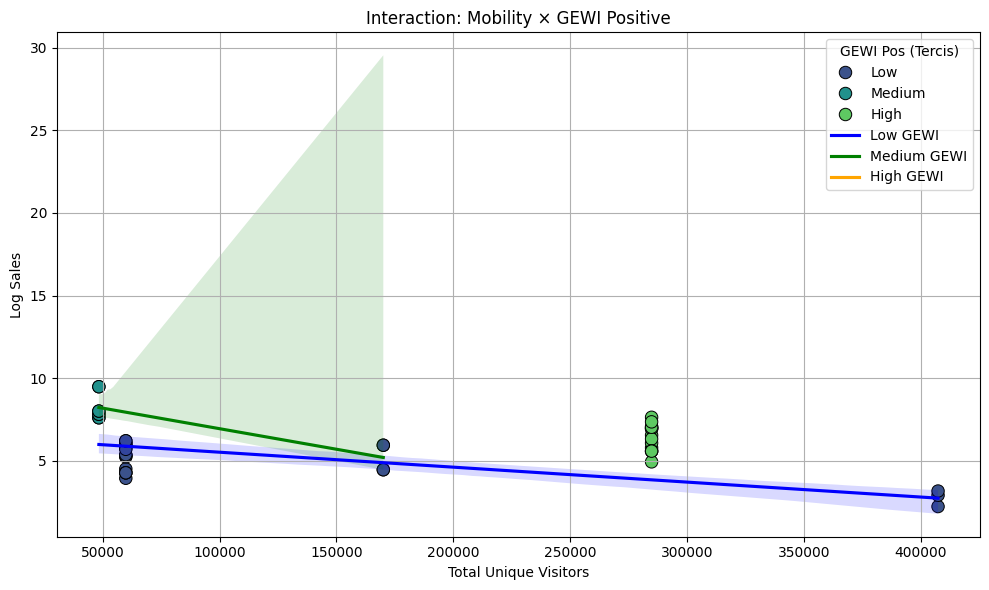

In [ ]:
# Title: Interaction Plot — Mobility × GEWI Positive (Tercis Only)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz"
df = pd.read_csv(path)

# Prepare variables
df = df.copy()
df = df[df["GEWI_v2_pos"] > 0]  # Use only rows with positive GEWI
df["log_sales"] = np.log1p(df["total_sales"])
df["tercil_pos"] = pd.qcut(
    df["GEWI_v2_pos"],
    q=3,
    labels=["Low", "Medium", "High"],
    duplicates="drop"
)

# Plot settings
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="total_unique_visitors",
    y="log_sales",
    hue="tercil_pos",
    palette="viridis",
    s=80,
    edgecolor="black"
)

# Add trend lines
sns.regplot(
    data=df[df["tercil_pos"] == "Low"],
    x="total_unique_visitors",
    y="log_sales",
    scatter=False,
    label="Low GEWI",
    color="blue"
)
sns.regplot(
    data=df[df["tercil_pos"] == "Medium"],
    x="total_unique_visitors",
    y="log_sales",
    scatter=False,
    label="Medium GEWI",
    color="green"
)
sns.regplot(
    data=df[df["tercil_pos"] == "High"],
    x="total_unique_visitors",
    y="log_sales",
    scatter=False,
    label="High GEWI",
    color="orange"
)

# Final touches
plt.title("Interaction: Mobility × GEWI Positive")
plt.xlabel("Total Unique Visitors")
plt.ylabel("Log Sales")
plt.legend(title="GEWI Pos (Tercis)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(df["GEWI_v2_pos"].describe())
print("\nUnique values:\n", df["GEWI_v2_pos"].value_counts())

count    47.000000
mean      0.509395
std       0.150904
min       0.349810
25%       0.410035
50%       0.410035
75%       0.720836
max       0.720836
Name: GEWI_v2_pos, dtype: float64

Unique values:
 GEWI_v2_pos
0.410035    17
0.720836    15
0.367773     4
0.490635     4
0.349810     3
0.486361     2
0.351332     2
Name: count, dtype: int64


In [ ]:
df_filtered = df[
    (df["log_sales"] < 12) &
    (df["total_unique_visitors"] < 500000)
]

In [ ]:
# Valores observados: 0.349810 → 0.410035 → 0.720836
bins = [0.34, 0.41, 0.55, 0.73]
labels = ["Low", "Medium", "High"]

df["tercil_pos"] = pd.cut(
    df["GEWI_v2_pos"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

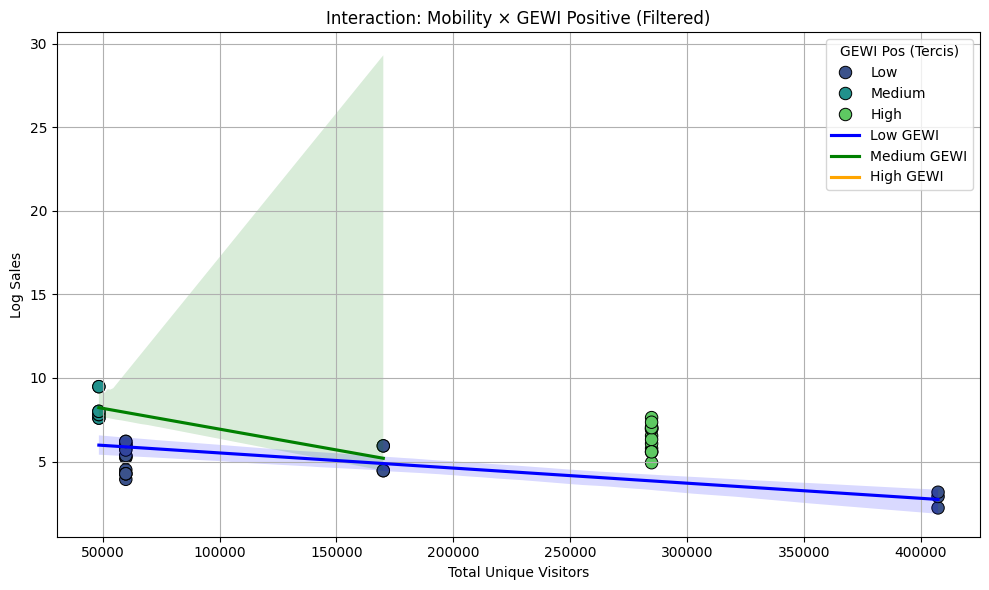

In [ ]:
# Recriar tercis (com dados filtrados)
df_filtered["tercil_pos"] = pd.qcut(
    df_filtered["GEWI_v2_pos"],
    q=3,
    labels=["Low", "Medium", "High"],
    duplicates="drop"
)

# Replot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered,
    x="total_unique_visitors",
    y="log_sales",
    hue="tercil_pos",
    palette="viridis",
    s=80,
    edgecolor="black"
)

# Trend lines
for tercil, color in zip(["Low", "Medium", "High"], ["blue", "green", "orange"]):
    subset = df_filtered[df_filtered["tercil_pos"] == tercil]
    if not subset.empty:
        sns.regplot(
            data=subset,
            x="total_unique_visitors",
            y="log_sales",
            scatter=False,
            label=f"{tercil} GEWI",
            color=color
        )

# Final plot settings
plt.title("Interaction: Mobility × GEWI Positive (Filtered)")
plt.xlabel("Total Unique Visitors")
plt.ylabel("Log Sales")
plt.legend(title="GEWI Pos (Tercis)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
##📊 Interaction Plot — Mobility × GEWI Negative (Filtered)

/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


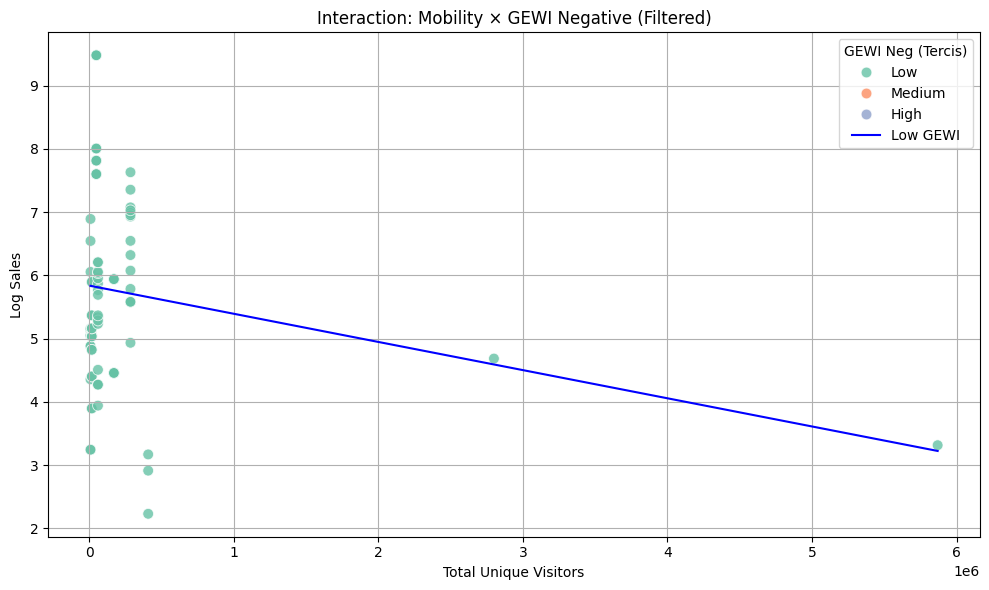

In [ ]:
# Title: Interaction Plot — Mobility × GEWI Negative (Filtered)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load final merged data (sales + mobility + GEWI)
df = pd.read_csv("/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz")
df["log_sales"] = np.log1p(df["total_sales"])

# Manual tercis (from GEWI_v2_neg.describe() and value_counts())
low_thres = 0.365
high_thres = 0.72

df_filtered = df[df["GEWI_v2_neg"].notna()].copy()
df_filtered["tercil_neg"] = pd.cut(
    df_filtered["GEWI_v2_neg"],
    bins=[-np.inf, low_thres, high_thres, np.inf],
    labels=["Low", "Medium", "High"]
)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered,
    x="total_unique_visitors",
    y="log_sales",
    hue="tercil_neg",
    palette="Set2",
    alpha=0.8,
    s=60
)

# Add regression lines per tercil
colors = {"Low": "blue", "Medium": "green", "High": "orange"}

for tercil in ["Low", "Medium", "High"]:
    subset = df_filtered[df_filtered["tercil_neg"] == tercil]
    if len(subset) > 1:
        model = LinearRegression()
        X = subset[["total_unique_visitors"]]
        y = subset["log_sales"]
        model.fit(X, y)
        x_range = np.linspace(X.min().values[0], X.max().values[0], 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        plt.plot(x_range, y_pred, label=f"{tercil} GEWI", color=colors[tercil])

plt.title("Interaction: Mobility × GEWI Negative (Filtered)")
plt.xlabel("Total Unique Visitors")
plt.ylabel("Log Sales")
plt.legend(title="GEWI Neg (Tercis)")
plt.grid(True)
plt.tight_layout()
plt.show()

/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


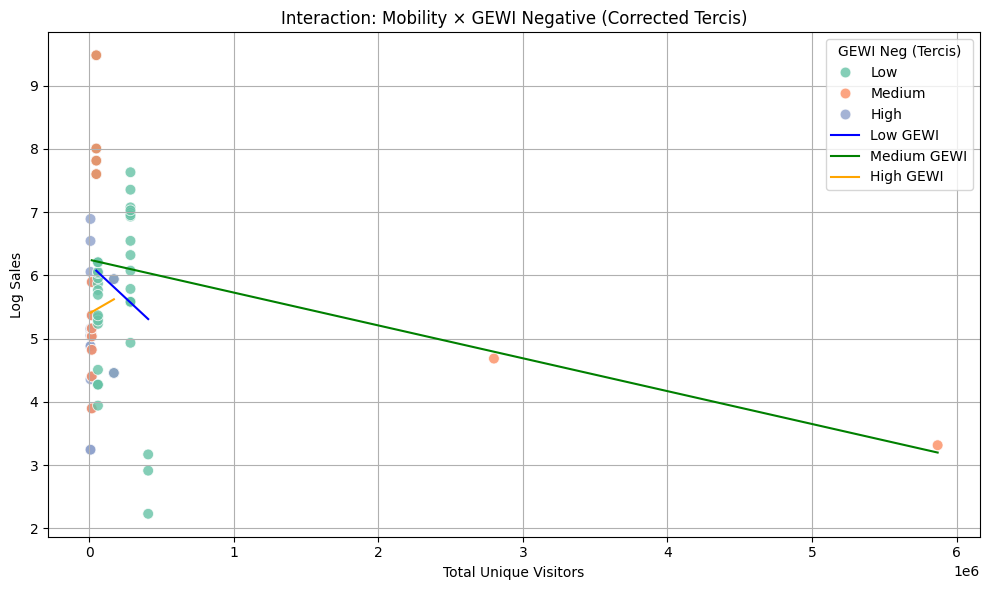

In [ ]:
# Title: Robust Interaction Plot — Mobility × GEWI Negative (Manual Terciles Fixed)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load final dataset
df = pd.read_csv("/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz")
df["log_sales"] = np.log1p(df["total_sales"])

# Manual tercis (ajustado com base nos valores únicos observados)
# Exemplo: use três thresholds bem separados com base nos percentis reais
neg_values = df["GEWI_v2_neg"].dropna()
q1 = neg_values.quantile(0.33)
q2 = neg_values.quantile(0.66)

# Evita bins duplicados forçando quebra mínima
if q1 == q2:
    q1 = neg_values.min() + 0.01
    q2 = neg_values.max() - 0.01

df_filtered = df[df["GEWI_v2_neg"].notna()].copy()
df_filtered["tercil_neg"] = pd.cut(
    df_filtered["GEWI_v2_neg"],
    bins=[-np.inf, q1, q2, np.inf],
    labels=["Low", "Medium", "High"]
)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered,
    x="total_unique_visitors",
    y="log_sales",
    hue="tercil_neg",
    palette="Set2",
    alpha=0.8,
    s=60
)

# Add regression lines per tercil
colors = {"Low": "blue", "Medium": "green", "High": "orange"}

for tercil in ["Low", "Medium", "High"]:
    subset = df_filtered[df_filtered["tercil_neg"] == tercil]
    if len(subset) > 1:
        model = LinearRegression()
        X = subset[["total_unique_visitors"]]
        y = subset["log_sales"]
        model.fit(X, y)
        x_range = np.linspace(X.min().values[0], X.max().values[0], 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        plt.plot(x_range, y_pred, label=f"{tercil} GEWI", color=colors[tercil])

plt.title("Interaction: Mobility × GEWI Negative (Corrected Tercis)")
plt.xlabel("Total Unique Visitors")
plt.ylabel("Log Sales")
plt.legend(title="GEWI Neg (Tercis)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
####🧪 Block 13 — Robustness & Validation: VIF, Collinearity, Interpolation Comparison

In [ ]:
# 📌 Title: Inspect Columns in Final Merged Dataset (GEWI + Mobility + Sales)

import pandas as pd

# File path
gewi_path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz"

# Load dataset
print("🔄 Loading merged dataset...")
df = pd.read_csv(gewi_path, low_memory=False)
print(f"✅ Loaded: {df.shape[0]:,} rows and {df.shape[1]} columns\n")

# Show all column names
print("🧾 Columns in dataset:")
for col in df.columns:
    print(f"• {col}")

# Show 5 sample rows
print("\n🔍 Sample rows:")
display(df.sample(5))

🔄 Loading merged dataset...
✅ Loaded: 96 rows and 38 columns

🧾 Columns in dataset:
• id
• invoice_number
• date
• customer_id
• customer_name
• product_code
• product_description
• items_quantity
• total_sales
• %_discount
• address
• address_complement
• address_number
• neighborhood
• zip_code
• city
• state_x
• customer_classification
• profit_center
• sales_rep
• company_code
• price_list
• Latitude
• Longitude
• CD_SETOR
• code_censo
• total_unique_visitors
• total_visits
• raw_unique_visitors
• raw_total_visits
• total_repeat_visitors
• total_new_visitors
• avg_dwell_time_mins
• state_y
• GEWI_v1
• GEWI_v2_pos
• GEWI_v2_neg
• GEWI_v3

🔍 Sample rows:


,id,invoice_number,date,customer_id,customer_name,product_code,product_description,items_quantity,total_sales,%_discount,...,raw_unique_visitors,raw_total_visits,total_repeat_visitors,total_new_visitors,avg_dwell_time_mins,state_y,GEWI_v1,GEWI_v2_pos,GEWI_v2_neg,GEWI_v3
57,97343,765672,2024-08-27,82.631.896/0001-71,Mateletrica Comercial Ltda,56135004,Arruela em Aluminio 1 Rosca Bsp,200,264.60000,20.0,...,2763.853688,10250.128524,1.934574e+05,2.848407e+05,30.619705,SC,0.720836,0.720836,0.000000,0.720836
0,11677,1164109,2024-08-06,04.732.670/0001-53,Comercial de Ferragens Morada do Sol Ltda,57115008,Int. Paralelo Baixo Branco 10a/250v,100,425.11000,0.0,...,65.953201,301.177765,6.322168e+03,8.340622e+03,46.590212,RS,0.311702,0.000000,0.311702,0.311702
75,123799,618064,2024-08-30,GF<T5D$__QT)#C='JS+']-,AJ`AWR/<B.``P#H(GI2$D.,57303002,Caixa + Tampa 2 Postos Lizflex,12,107.21004,0.0,...,25072.259601,81030.709743,1.888930e+06,2.799481e+06,29.568588,RJ,0.220170,0.000000,0.220170,0.220170
11,57198,1168530,2024-08-19,04.732.670/0001-53,Comercial de Ferragens Morada do Sol Ltda,57258002,Curva Longa 90 Grs 3/4 Cinza Escuro,20,130.78000,0.0,...,65.953201,301.177765,6.322168e+03,8.340622e+03,46.590212,RS,0.311702,0.000000,0.311702,0.311702
35,7812,2205462,2024-08-05,33.167.223/0001-05,Eletrica Casa Ferreira Ltda,56114007,Tampa Cega Estampada 1,36,85.19040,0.0,...,1548.185553,6534.167164,1.257594e+05,1.700518e+05,43.928974,MG,0.530846,0.351332,0.318521,0.521662


✅ Dataset loaded: (96, 38)

📏 Variance Inflation Factor (VIF):


,Variable,VIF
0,const,26.845612
1,total_unique_visitors,238.605766
2,GEWI_v2_pos,11.111900
3,GEWI_v2_neg,6.929803
4,mob_x_pos,13.429689
5,mob_x_neg,238.046127



📊 Re-estimated Model Summary (with VIF variables):
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     4.334
Date:                Wed, 14 May 2025   Prob (F-statistic):            0.00140
Time:                        09:13:22   Log-Likelihood:                -165.01
No. Observations:                  96   AIC:                             342.0
Df Residuals:                      90   BIC:                             357.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

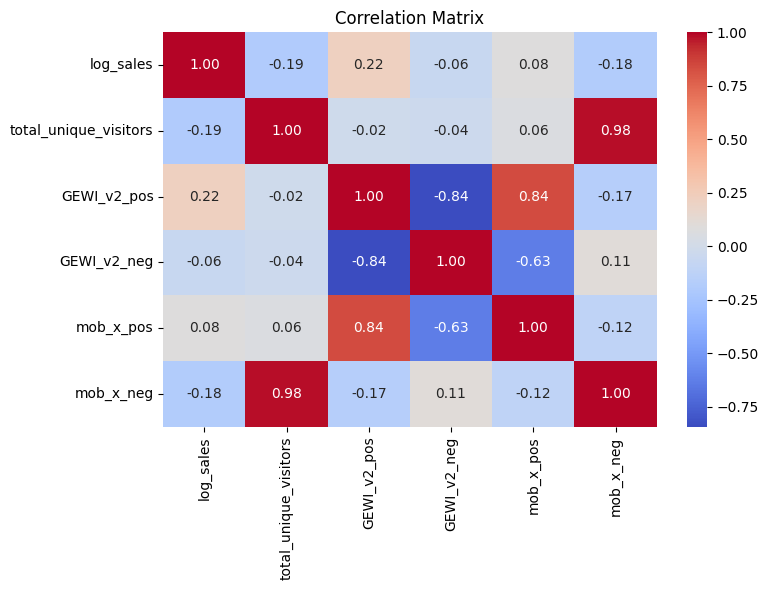

In [ ]:
# 🧪 Block 13 — Robustness & Validation: VIF, Collinearity, Interpolation Comparison

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Load dataset
path = "/n/netscratch/cga/Lab/rpalbuquerque/Hypothesis_Test/sales_mobility_gewi_expanded.csv.gz"
df = pd.read_csv(path)
print(f"✅ Dataset loaded: {df.shape}")

# 🧹 Prepare data
df = df.copy()
df = df.dropna(subset=["total_sales", "total_unique_visitors", "GEWI_v2_pos", "GEWI_v2_neg"])
df["log_sales"] = np.log1p(df["total_sales"])
df["mob_x_pos"] = df["total_unique_visitors"] * df["GEWI_v2_pos"]
df["mob_x_neg"] = df["total_unique_visitors"] * df["GEWI_v2_neg"]

# 📊 VIF Calculation
X = df[["total_unique_visitors", "GEWI_v2_pos", "GEWI_v2_neg", "mob_x_pos", "mob_x_neg"]]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\n📏 Variance Inflation Factor (VIF):")
display(vif_data)

# 📈 Re-run regression for comparison
model = sm.OLS(df["log_sales"], X).fit()
print("\n📊 Re-estimated Model Summary (with VIF variables):")
print(model.summary())

# 📉 Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[["log_sales", "total_unique_visitors", "GEWI_v2_pos", "GEWI_v2_neg", "mob_x_pos", "mob_x_neg"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()